Appendix
This appendix is a context of the data processing, graphing, modelling and clustering process based on python

First step, import relative libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import json
from statsmodels.formula import api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans

Second step, import dataset and process

In [6]:
path = './TGood_dataset.csv'
df = pd.read_csv(path, encoding = 'gbk') # chinese encoding
df.head()

,station name,station location,province,lng_lat,rating,operation type,is open,is outdoor,floor,is free parking,dc number,ac number,electricity price,service price,ownership,other
0,毅威出行老周谷堆充电站,安徽省合肥市包河区巢湖南路与周谷堆路交口周谷堆汽车城内停车场(阿虎车行后面),Anhui,"117.309517, 31.846961999999998",4.5,non_self_operated,yes,outdoor,1,limited time,25,0,time：00:00-08:00 price：0.3769|time：08:00-09:00...,time：00:00-08:00 price：0.5000|time：08:00-09:00...,合肥市毅威电动汽车投资运营有限公司,非自营|对外开放|露天|限时免费停车|discount|maximum power per ...
1,特来电蓝钻尚界充电站,安徽省合肥市庐阳区亳州路街道北一环路蓝钻尚界,Anhui,"117.25945800000001, 31.878163",4.5,self_operated,yes,outdoor,1,limited time,12,0,time：00:00-08:00 price：0.4069|time：08:00-09:00...,time：00:00-08:00 price：0.5200|time：08:00-09:00...,合肥特来电汽车充电有限公司,特来电权益|自营|对外开放|露天1F|限时免费停车|芝麻信用·免充值|discount|re...
2,星星充电合肥市周谷堆汽车城,合肥市包河区周谷堆汽车城,Anhui,"117.30954399999999, 31.845805",5.0,interconnection,yes,indoor,1,no,18,0,time：00:00-08:00 price：0.3599|time：08:00-09:00...,time：00:00-08:00 price：0.5000|time：08:00-09:00...,特来电新能源股份有限公司,互联互通|对外开放|芝麻信用·免充值
3,毅威出行东方摩域充电站,安徽省合肥市瑶海区当涂路200号，东方摩域艺术广场东侧停车场,Anhui,"117.339578, 31.859153000000003",4.5,non_self_operated,yes,outdoor,1,limited time,18,0,time：00:00-08:00 price：0.3745|time：08:00-09:00...,time：00:00-08:00 price：0.5000|time：08:00-09:00...,合肥市毅威电动汽车投资运营有限公司,非自营|对外开放|露天|限时免费停车|discount|refundable|maximum...
4,特来电正业大厦充电站,安徽省合肥市瑶海区长淮街道北二环路170号平之梦假日酒店（禁止电车占位！发现将拉黑处理）,Anhui,"117.305756, 31.893576",4.3,self_operated,yes,outdoor,1,limited time,12,0,time：00:00-08:00 price：0.4397|time：08:00-09:00...,time：00:00-08:00 price：0.5200|time：08:00-09:00...,合肥特来电汽车充电有限公司,特来电权益|自营|对外开放|露天1F|限时免费停车|芝麻信用·免充值|discount|re...


Data pre-processing using the method in the thesis is divided into three main steps. 
first, pick out the fields of refundable and discount in the 'other' label, 
second, conduct dummy variable processing,
finally substitute into the formula to get the weighted price of electricity and service price.

In [7]:
def f1(other):
    if 'refundable' in other:
        return 1
    else:
        return 0

def f2(other):
    if 'discount' in other:
        return 1
    else:
        return 0

# Converting the input fields into a dictionary and weighting them by the length of time
def f3(fee):
    if '|' in fee:
        price = 0
        a = fee.split("|")
        for i in a:
            p = json.loads("{" + i.replace('time：', '"time":"').replace(' price：', '", "price":"') + '"}')
            s = p['time'].split("-")
            try:
                price += (int(s[1][:2]) - int(s[0][:2]))/24 * float(p['price'])
            except:
                price += 0
        return price
    else:
        return 0

    
df['refundable'] = df['other'].apply(f1)
df['discount'] = df['other'].apply(f2)
df['elec_fee'] = df['electricity price'].apply(f3)
df['serv_fee'] = df['service price'].apply(f3)
df['rating'] = df['rating'].apply(lambda x: float(x))

# select and rename the columns
df_new = df[['station name', 'province', 'lng_lat', 'rating', 'operation type', 
             'is open', 'is outdoor', 'floor', 'is free parking', 'discount', 
             'refundable', 'elec_fee', 'serv_fee', 'dc number', 'ac number']]
df_new.columns = ['station_name', 'province', 'lng_lat', 'rating', 'operation_type', 
             'is_open', 'is_outdoor', 'floor', 'is_free_parking', 'discount', 
             'refundable', 'elec_fee', 'serv_fee', 'dc_number', 'ac_number']

# use dropna to remove the rating fields with NaN value
df_new = df_new.dropna(how = 'any')
df_new.head()

,station_name,province,lng_lat,rating,operation_type,is_open,is_outdoor,floor,is_free_parking,discount,refundable,elec_fee,serv_fee,dc_number,ac_number
0,毅威出行老周谷堆充电站,Anhui,"117.309517, 31.846961999999998",4.5,non_self_operated,yes,outdoor,1,limited time,1,0,0.636071,0.500000,25,0
1,特来电蓝钻尚界充电站,Anhui,"117.25945800000001, 31.878163",4.5,self_operated,yes,outdoor,1,limited time,1,1,0.655538,0.480417,12,0
2,星星充电合肥市周谷堆汽车城,Anhui,"117.30954399999999, 31.845805",5.0,interconnection,yes,indoor,1,no,0,0,0.599604,0.500000,18,0
3,毅威出行东方摩域充电站,Anhui,"117.339578, 31.859153000000003",4.5,non_self_operated,yes,outdoor,1,limited time,1,1,0.637500,0.500000,18,0
4,特来电正业大厦充电站,Anhui,"117.305756, 31.893576",4.3,self_operated,yes,outdoor,1,limited time,1,1,0.703538,0.482083,12,0


In [8]:
# verify whether rating is not empty

df_new.isna().sum()

station_name       0
province           0
lng_lat            0
rating             0
operation_type     0
is_open            0
is_outdoor         0
floor              0
is_free_parking    0
discount           0
refundable         0
elec_fee           0
serv_fee           0
dc_number          0
ac_number          0
dtype: int64

Third step, do some data visualisation work, make various plots

,province,count
0,Anhui,168
1,Beijing,288
2,Chongqing,288
3,Fujian,646
4,Gansu,85
5,Guangdong,520
6,Guangxi,128
7,Guizhou,135
8,Hainan,185
9,Hebei,579


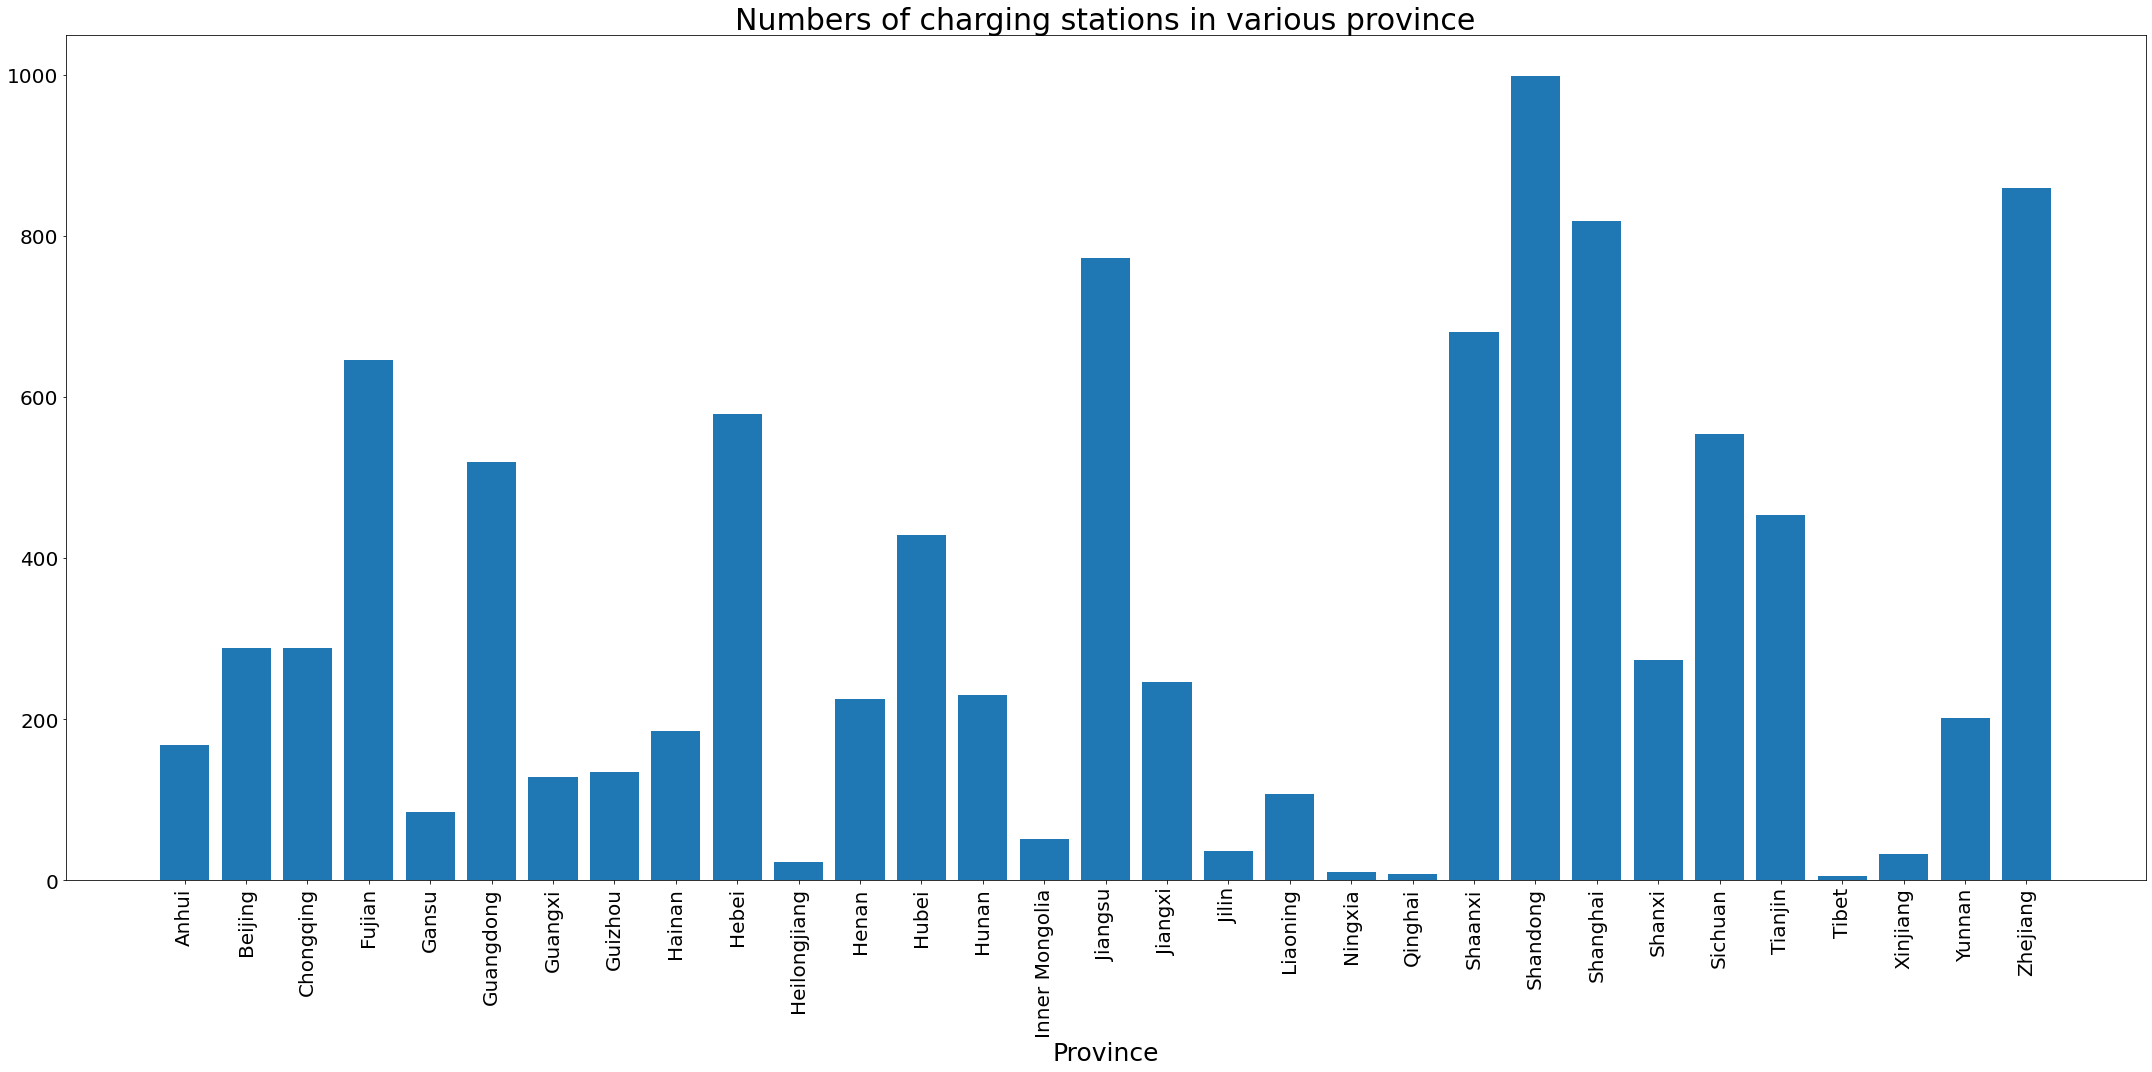

In [24]:
# count stations based on province dimension

df_province = df_new.groupby('province')['station_name'].agg(['count']).reset_index()
display(df_province)
fig = plt.figure(figsize = (30, 15))
plt.bar(df_province['province'], df_province['count'])
plt.xlabel('Province', fontsize = 25)
plt.subplots_adjust(left = 0.1, right = 1.1, top = 0.8, bottom = 0.1)
plt.xticks(df_province['province'], color = 'black', rotation = 90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Numbers of charging stations in various province', fontsize = 30)
plt.tight_layout()
plt.show()

,province,mean
0,Anhui,4.016071
1,Beijing,3.711806
2,Chongqing,3.655556
3,Fujian,3.781269
4,Gansu,4.001176
5,Guangdong,3.711923
6,Guangxi,3.744531
7,Guizhou,3.832593
8,Hainan,3.674054
9,Hebei,4.178238


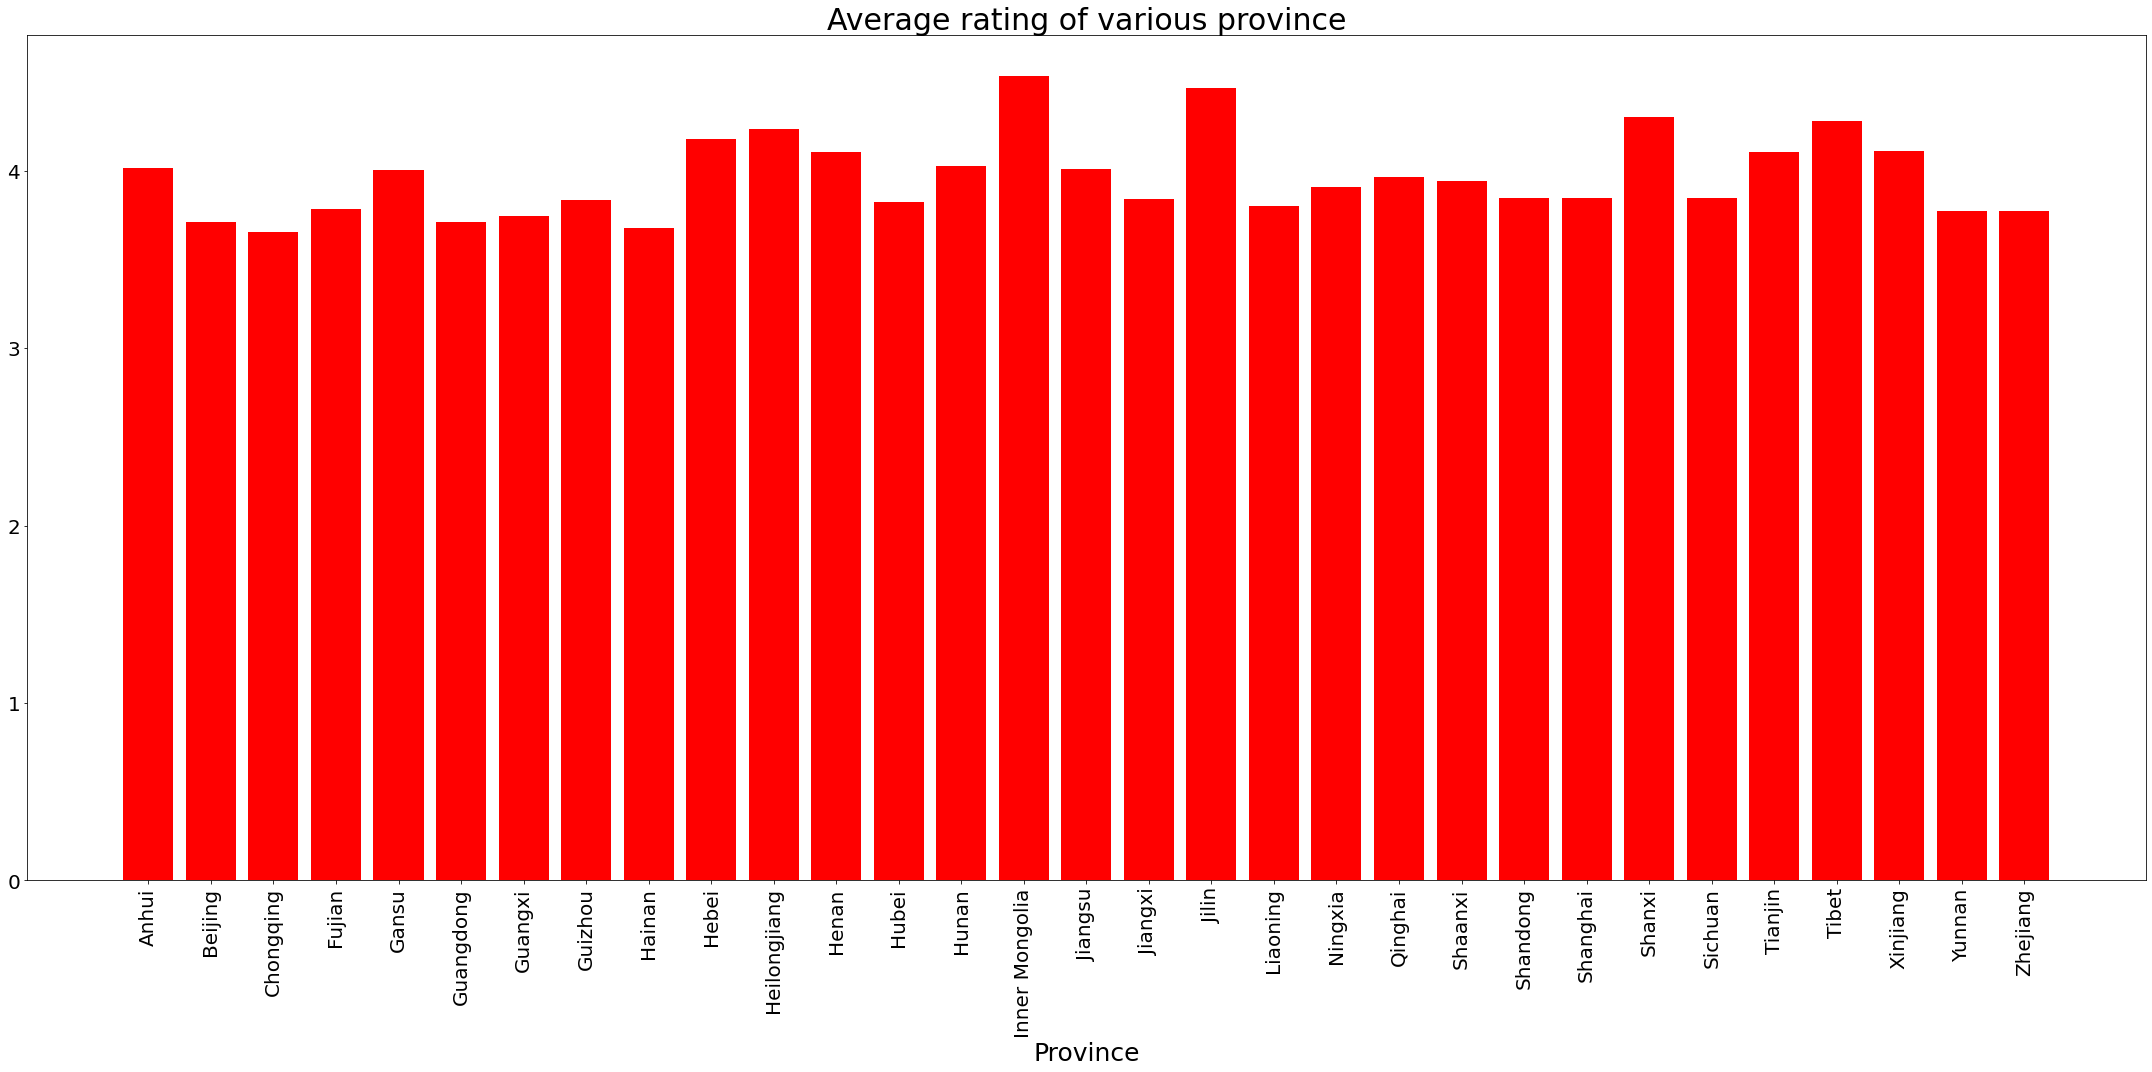

In [25]:
# average rating based on different provinces

df_rating = df_new.groupby('province')['rating'].agg(['mean']).reset_index()
display(df_rating)
fig = plt.figure(figsize = (30, 15))
plt.bar(df_rating['province'], df_rating['mean'], color = 'r')
plt.xlabel('Province', fontsize = 25)
plt.subplots_adjust(left = 0.1, right = 1.1, top = 0.8, bottom = 0.1)
plt.xticks(df_rating['province'], color = 'black', rotation = 90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Average rating of various province', fontsize = 30)
plt.tight_layout()
plt.show()

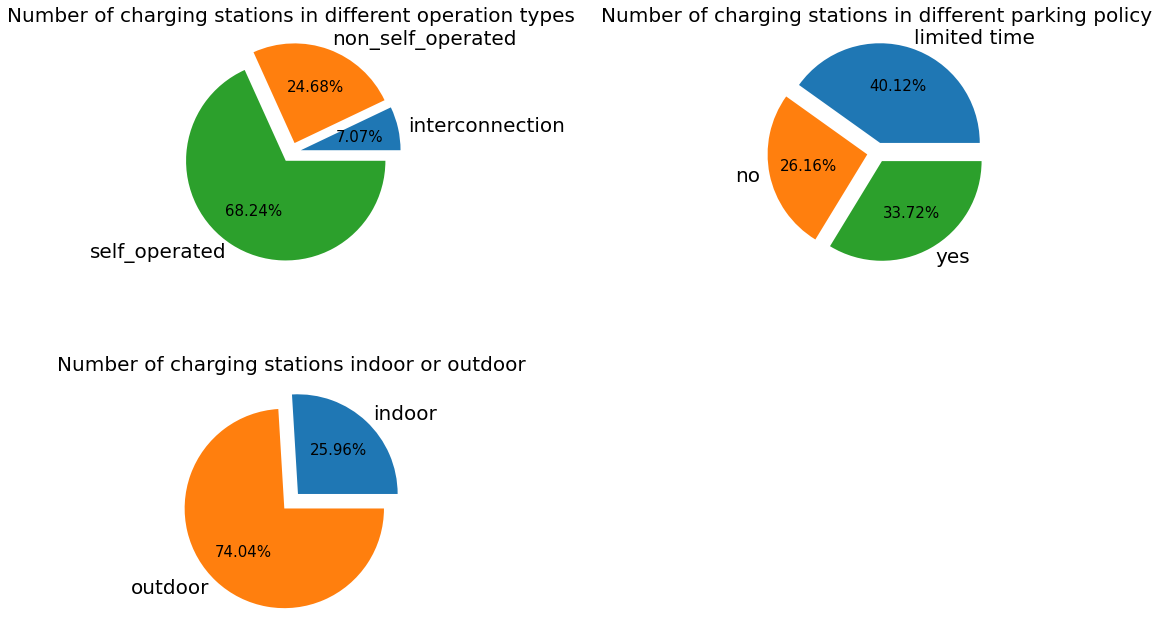

In [53]:
# finish three pie charts

df_operation = df_new.groupby('operation_type')['station_name'].agg(['count']).reset_index()
df_park = df_new.groupby('is_free_parking')['station_name'].agg(['count']).reset_index()
df_outdoor = df_new.groupby('is_outdoor')['station_name'].agg(['count']).reset_index()
# subplot
fig = plt.figure(figsize = (20, 11))
axes1 = fig.add_subplot(2,2,1)
axes2 = fig.add_subplot(2,2,2)
axes3 = fig.add_subplot(2,2,3)

a, b, c = axes1.pie(df_operation['count'], labels = df_operation['operation_type'], explode=(0.1, 0.1, 0.1), autopct='%.2f%%', textprops = {'fontsize':15})
axes1.set_title('Number of charging stations in different operation types', fontsize = 20)

d, e, f = axes2.pie(df_park['count'], labels = df_park['is_free_parking'], explode=(0.1, 0.1, 0.1), autopct='%.2f%%', textprops = {'fontsize':15})
axes2.set_title('Number of charging stations in different parking policy', fontsize = 20)

g, h ,i = axes3.pie(df_outdoor['count'], labels = df_outdoor['is_outdoor'], explode=(0.1, 0.1), autopct='%.2f%%', textprops = {'fontsize':15})
axes3.set_title('Number of charging stations indoor or outdoor', fontsize = 20)

for s in b:
    s.set_size(20)
for p in e:
    p.set_size(20)
for m in h:
    m.set_size(20)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

Fourth step, continue to work on the data until it can be substituted into the model

In [28]:
# get dummies of those string variables and take their dummy variables

x_part = df_new[['operation_type','is_open','is_outdoor','is_free_parking', 'refundable', 'discount']]

hot_encoder = OneHotEncoder(drop='first', handle_unknown="ignore", sparse=False)  # retain n-1 vairables
hot_encoder.fit(x_part)
x_dummies = pd.DataFrame(hot_encoder.transform(x_part), columns=hot_encoder.get_feature_names_out(x_part.columns))
x_dummies.head()

,operation_type_non_self_operated,operation_type_self_operated,is_outdoor_outdoor,is_free_parking_no,is_free_parking_yes,refundable_1,discount_1
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [29]:
# concatenate with the original numerical variables and get their descriptive statistics result

x_another_part = df_new[['floor', 'elec_fee', 'serv_fee', 'dc_number', 'ac_number', 'rating']]
df_descriptive = pd.concat([x_dummies, x_another_part], axis = 1)
df_descriptive.describe()

,operation_type_non_self_operated,operation_type_self_operated,is_outdoor_outdoor,is_free_parking_no,is_free_parking_yes,refundable_1,discount_1,floor,elec_fee,serv_fee,dc_number,ac_number,rating
count,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000,10039.000000
mean,0.246837,0.682438,0.740412,0.261580,0.337185,0.654846,0.692898,0.591991,0.347227,0.239444,11.532822,3.141249,3.895677
std,0.431193,0.465551,0.438430,0.439517,0.472772,0.475442,0.461315,0.989222,0.314953,0.246410,13.043465,8.646253,0.899835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,3.500000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.515500,0.250000,8.000000,0.000000,4.100000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.618263,0.432758,16.000000,4.000000,4.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.693000,1.300000,182.000000,211.000000,5.000000


In [30]:
# normalise the columns which are the numerical variables

mms = MinMaxScaler()
x_norm = pd.DataFrame(mms.fit_transform(x_another_part), columns=x_another_part.columns)
x_norm.head()

,floor,elec_fee,serv_fee,dc_number,ac_number,rating
0,0.5,0.375706,0.384615,0.137363,0.0,0.875
1,0.5,0.387205,0.369551,0.065934,0.0,0.875
2,0.5,0.354167,0.384615,0.098901,0.0,1.000
3,0.5,0.376551,0.384615,0.098901,0.0,0.875
4,0.5,0.415557,0.370833,0.065934,0.0,0.825


In [31]:
df_sum = pd.concat([x_dummies, x_norm], axis = 1)
display(df_sum.head())
# at this time, the two parts of the data have been concatenated together and can be used as input to the model

,operation_type_non_self_operated,operation_type_self_operated,is_outdoor_outdoor,is_free_parking_no,is_free_parking_yes,refundable_1,discount_1,floor,elec_fee,serv_fee,dc_number,ac_number,rating
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.5,0.375706,0.384615,0.137363,0.0,0.875
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.5,0.387205,0.369551,0.065934,0.0,0.875
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.354167,0.384615,0.098901,0.0,1.000
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.5,0.376551,0.384615,0.098901,0.0,0.875
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.5,0.415557,0.370833,0.065934,0.0,0.825


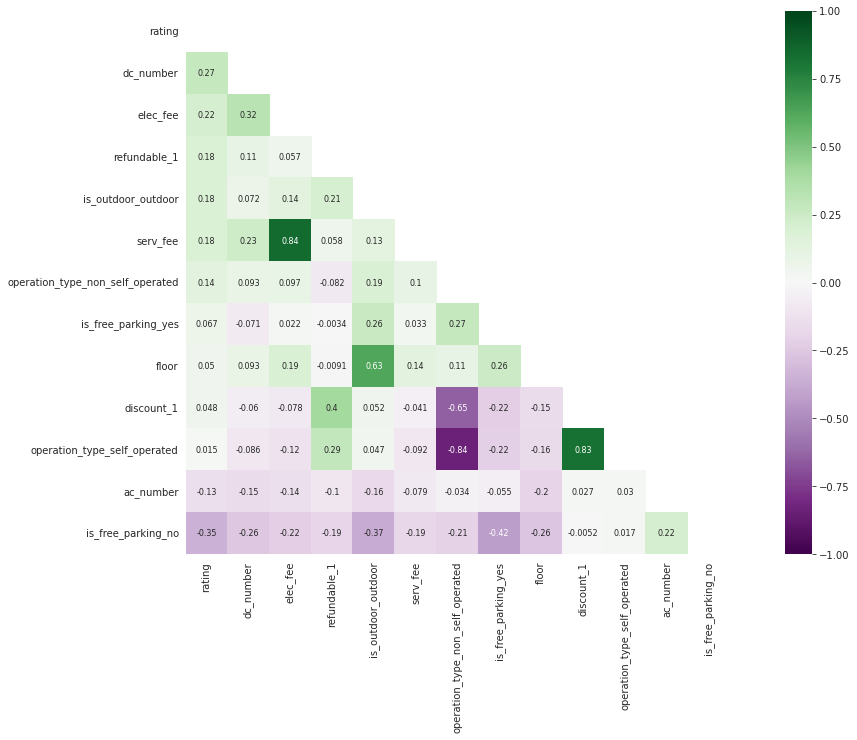

In [32]:
# Correlation coefficient matrix validation

f_data = df_sum
f_number = 13
f_feature = 'rating'

f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
f_correlation = f_data[f_most_correlated].corr()

f_mask = np.zeros_like(f_correlation)
f_mask[np.triu_indices_from(f_mask)] = True
with sns.axes_style("white"):
    f_fig, f_ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
plt.show()

Fifth step, select the independent variable in the scale [-0.5,0.5] and substitute it into the regression model, and then, 8 variables remain (see them in the formula)

In [33]:
formula = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+elec_fee+dc_number+ac_number'
model = smf.ols(formula = formula, data = df_sum).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     281.4
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:13:18   Log-Likelihood:                 1748.9
No. Observations:               10039   AIC:                            -3480.
Df Residuals:                   10030   BIC:                            -3415.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6679      0.007     89.852      0.000       0.653       0.682
operation_type_self_operated     0.0019      0.005      0.393      0.695      -0.007       0.011
is_free_parking_no              -0.1386      0.006    -23.994      0.000      -0.150      -0.127
is_free_parking_yes             -0.0243      0.005     -4.793      0.000      -0.034      -0.014
refundable_1                     0.0461      0.005      9.962      0.000       0.037       0.055
is_outdoor_outdoor               0.0227      0.005      4.429      0.000       0.013       0.033
elec_fee                         0.1154      0.012      9.791      0.000       0.092       0.139
dc_number                        0.4817      0.031     15.313      0.000       0.420       0.543
ac_number                       -0.1311      0.051     -2.549      0.011      -0.232      -0.030
==============================================================================
Omnibus:                     1849.633   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3816.377
Skew:                          -1.096   Prob(JB):                         0.00
Kurtosis:                       5.079   Cond. No.                         42.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# verify the variable inflation factors table

X = df_sum[['operation_type_self_operated','is_free_parking_no','is_free_parking_yes','refundable_1','is_outdoor_outdoor','elec_fee','dc_number','ac_number']]
vif = np.array([variance_inflation_factor(exog=X.values, exog_idx=i) for i in range(X.shape[1])])
vif_table = pd.DataFrame([X.columns, vif])  
display(vif_table)

,0,1,2,3,4,5,6,7
0,operation_type_self_operated,is_free_parking_no,is_free_parking_yes,refundable_1,is_outdoor_outdoor,elec_fee,dc_number,ac_number
1,3.06437,1.39791,1.71579,3.22816,3.84233,2.34297,1.96179,1.19257


in order to get higher R-squared, the following tests are made

In [37]:
# try to use the square of elec_fee, dc_number and ac_number

formula2 = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+I(elec_fee**2)+I(dc_number**2)+I(ac_number**2)'
model2 = smf.ols(formula = formula2, data = df_sum).fit()
display(model2.summary())

formula3 = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+I(elec_fee**2)+dc_number+ac_number'
model3 = smf.ols(formula = formula3, data = df_sum).fit()
display(model3.summary())

formula4 = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+elec_fee**2+I(dc_number**2)+ac_number'
model4 = smf.ols(formula = formula4, data = df_sum).fit()
display(model4.summary())

formula5 = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+elec_fee+dc_number+I(ac_number**2)'
model5 = smf.ols(formula = formula5, data = df_sum).fit()
display(model5.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     245.1
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:22:20   Log-Likelihood:                 1628.6
No. Observations:               10039   AIC:                            -3239.
Df Residuals:                   10030   BIC:                            -3174.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.7058      0.007    101.727      0.000       0.692       0.719
operation_type_self_operated    -0.0073      0.005     -1.515      0.130      -0.017       0.002
is_free_parking_no              -0.1657      0.006    -29.712      0.000      -0.177      -0.155
is_free_parking_yes             -0.0414      0.005     -8.246      0.000      -0.051      -0.032
refundable_1                     0.0515      0.005     11.038      0.000       0.042       0.061
is_outdoor_outdoor               0.0254      0.005      4.912      0.000       0.015       0.036
I(elec_fee ** 2)                 0.2924      0.027     10.868      0.000       0.240       0.345
I(dc_number ** 2)                0.5727      0.069      8.331      0.000       0.438       0.707
I(ac_number ** 2)                0.0892      0.096      0.931      0.352      -0.098       0.277
==============================================================================
Omnibus:                     1884.737   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3833.265
Skew:                          -1.122   Prob(JB):                         0.00
Kurtosis:                       5.032   Cond. No.                         77.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     277.0
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:22:20   Log-Likelihood:                 1734.3
No. Observations:               10039   AIC:                            -3451.
Df Residuals:                   10030   BIC:                            -3386.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6746      0.007     91.910      0.000       0.660       0.689
operation_type_self_operated     0.0004      0.005      0.087      0.931      -0.009       0.010
is_free_parking_no              -0.1422      0.006    -24.701      0.000      -0.154      -0.131
is_free_parking_yes             -0.0255      0.005     -5.022      0.000      -0.035      -0.016
refundable_1                     0.0456      0.005      9.834      0.000       0.036       0.055
is_outdoor_outdoor               0.0242      0.005      4.708      0.000       0.014       0.034
I(elec_fee ** 2)                 0.2207      0.027      8.156      0.000       0.168       0.274
dc_number                        0.5101      0.031     16.410      0.000       0.449       0.571
ac_number                       -0.1406      0.051     -2.730      0.006      -0.241      -0.040
==============================================================================
Omnibus:                     1863.840   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3850.118
Skew:                          -1.103   Prob(JB):                         0.00
Kurtosis:                       5.083   Cond. No.                         42.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     255.3
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:22:20   Log-Likelihood:                 1662.7
No. Observations:               10039   AIC:                            -3307.
Df Residuals:                   10030   BIC:                            -3242.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6977      0.007     97.597      0.000       0.684       0.712
operation_type_self_operated    -0.0038      0.005     -0.787      0.431      -0.013       0.006
is_free_parking_no              -0.1558      0.006    -27.441      0.000      -0.167      -0.145
is_free_parking_yes             -0.0376      0.005     -7.490      0.000      -0.047      -0.028
refundable_1                     0.0506      0.005     10.888      0.000       0.042       0.060
is_outdoor_outdoor               0.0216      0.005      4.165      0.000       0.011       0.032
elec_fee                         0.1506      0.012     13.004      0.000       0.128       0.173
I(dc_number ** 2)                0.5306      0.069      7.724      0.000       0.396       0.665
ac_number                       -0.1765      0.052     -3.409      0.001      -0.278      -0.075
==============================================================================
Omnibus:                     1875.097   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3829.366
Skew:                          -1.115   Prob(JB):                         0.00
Kurtosis:                       5.046   Cond. No.                         56.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     280.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:22:21   Log-Likelihood:                 1746.4
No. Observations:               10039   AIC:                            -3475.
Df Residuals:                   10030   BIC:                            -3410.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6644      0.007     90.248      0.000       0.650       0.679
operation_type_self_operated     0.0014      0.005      0.290      0.772      -0.008       0.011
is_free_parking_no              -0.1407      0.006    -24.556      0.000      -0.152      -0.130
is_free_parking_yes             -0.0248      0.005     -4.886      0.000      -0.035      -0.015
refundable_1                     0.0469      0.005     10.138      0.000       0.038       0.056
is_outdoor_outdoor               0.0242      0.005      4.724      0.000       0.014       0.034
elec_fee                         0.1171      0.012      9.944      0.000       0.094       0.140
dc_number                        0.4879      0.031     15.540      0.000       0.426       0.549
I(ac_number ** 2)                0.1172      0.095      1.239      0.215      -0.068       0.303
==============================================================================
Omnibus:                     1836.771   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3771.556
Skew:                          -1.091   Prob(JB):                         0.00
Kurtosis:                       5.063   Cond. No.                         78.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Each of the four models above squared all three numerical variables and each of them individually, but none of them yielded better results.

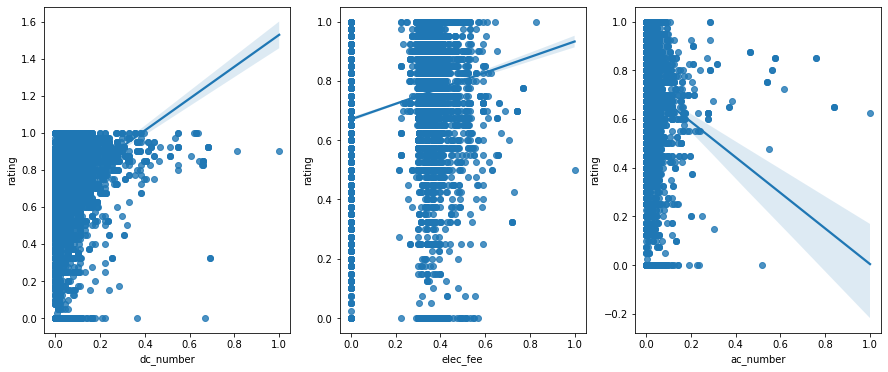

In [42]:
# try to draw regression plot to there numerical variables

fig = plt.figure(figsize = (15,6))
plot1 = fig.add_subplot(131)
plot1 = sns.regplot(x = df_sum['dc_number'], y = df_sum['rating'], data = df_sum)
plot2 = fig.add_subplot(132)
plot2 = sns.regplot(x = df_sum['elec_fee'], y = df_sum['rating'], data = df_sum)
plot3 = fig.add_subplot(133)
plot3 = sns.regplot(x = df_sum['ac_number'], y = df_sum['rating'], data = df_sum)
plt.show()

It seems that the logarithm of dc_number has a linear relationship with rating. therefore, take logarithm of dc_number.

In [43]:
# remove the whole records which dc_number is equal to 0

df_9163 = df_sum.drop(df_sum[df_sum['dc_number'] == 0].index)
df_9163.describe()
# it remains 9163 records, then name this dataset by 9163

,operation_type_non_self_operated,operation_type_self_operated,is_outdoor_outdoor,is_free_parking_no,is_free_parking_yes,refundable_1,discount_1,floor,elec_fee,serv_fee,dc_number,ac_number,rating
count,9163.000000,9163.000000,9163.000000,9163.00000,9163.000000,9163.000000,9163.000000,9163.000000,9163.000000,9163.000000,9163.000000,9163.000000,9163.000000
mean,0.245662,0.686675,0.757503,0.23082,0.343665,0.713740,0.701517,0.463451,0.215408,0.191696,0.069425,0.011036,0.737452
std,0.430502,0.463871,0.428617,0.42138,0.474957,0.452037,0.457617,0.094541,0.183937,0.186897,0.072157,0.028761,0.212982
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005495,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.021978,0.000000,0.650000
50%,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.500000,0.307147,0.198122,0.054945,0.000000,0.800000
75%,0.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,0.500000,0.365188,0.346154,0.098901,0.009479,0.875000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.923077,1.000000,0.616114,1.000000


In [44]:
formula_9163 = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+elec_fee+np.log(dc_number)+ac_number'
model_9163 = smf.ols(formula = formula_9163, data = df_9163).fit()
model_9163.summary()

# R-squared = 0.207, larger than before

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     298.8
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:34:28   Log-Likelihood:                 2232.8
No. Observations:                9163   AIC:                            -4448.
Df Residuals:                    9154   BIC:                            -4384.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.8706      0.010     89.544      0.000       0.852       0.890
operation_type_self_operated     0.0001      0.005      0.031      0.975      -0.009       0.009
is_free_parking_no              -0.1197      0.006    -20.214      0.000      -0.131      -0.108
is_free_parking_yes             -0.0004      0.005     -0.078      0.938      -0.010       0.009
refundable_1                     0.0436      0.005      9.270      0.000       0.034       0.053
is_outdoor_outdoor               0.0207      0.005      4.087      0.000       0.011       0.031
elec_fee                         0.0564      0.012      4.665      0.000       0.033       0.080
np.log(dc_number)                0.0512      0.002     21.606      0.000       0.047       0.056
ac_number                       -0.4238      0.071     -5.928      0.000      -0.564      -0.284
==============================================================================
Omnibus:                     1966.483   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4815.206
Skew:                          -1.186   Prob(JB):                         0.00
Kurtosis:                       5.643   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
'''In order to test the conjecture, 
the model was redone with all independent variables as a single square on the basis of 9163 data
'''

formula_test = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+elec_fee+dc_number+ac_number'
model_test = smf.ols(formula = formula_test, data = df_9163).fit()
model_test.summary()

# taking logarithms have better results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     260.3
Date:                Wed, 12 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:39:15   Log-Likelihood:                 2108.9
No. Observations:                9163   AIC:                            -4200.
Df Residuals:                    9154   BIC:                            -4136.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.6855      0.008     90.957      0.000       0.671       0.700
operation_type_self_operated    -0.0059      0.005     -1.227      0.220      -0.015       0.004
is_free_parking_no              -0.1443      0.006    -24.889      0.000      -0.156      -0.133
is_free_parking_yes             -0.0208      0.005     -4.203      0.000      -0.030      -0.011
refundable_1                     0.0460      0.005      9.648      0.000       0.037       0.055
is_outdoor_outdoor               0.0189      0.005      3.682      0.000       0.009       0.029
elec_fee                         0.1099      0.012      9.325      0.000       0.087       0.133
dc_number                        0.4404      0.030     14.492      0.000       0.381       0.500
ac_number                       -0.4511      0.072     -6.227      0.000      -0.593      -0.309
==============================================================================
Omnibus:                     1994.510   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4806.904
Skew:                          -1.209   Prob(JB):                         0.00
Kurtosis:                       5.597   Cond. No.                         61.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# verify taking logarithms in elec_fee

df_5664 = df_sum.drop(df_sum[df_sum['elec_fee'] == 0].index)
df_5664.describe() # remaining 5664 records

formula_verify = 'rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+np.log(elec_fee)+dc_number+ac_number'
model_verify = smf.ols(formula = formula_verify, data = df_elec).fit()
model_verify.summary()

# worse results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     126.5
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.01e-195
Time:                        14:42:59   Log-Likelihood:                 1763.0
No. Observations:                5664   AIC:                            -3508.
Df Residuals:                    5655   BIC:                            -3448.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.7097      0.019     37.233      0.000       0.672       0.747
operation_type_self_operated    -0.0122      0.005     -2.269      0.023      -0.023      -0.002
is_free_parking_no              -0.1534      0.008    -19.785      0.000      -0.169      -0.138
is_free_parking_yes             -0.0229      0.006     -4.127      0.000      -0.034      -0.012
refundable_1                     0.0450      0.006      8.057      0.000       0.034       0.056
is_outdoor_outdoor               0.0157      0.006      2.417      0.016       0.003       0.028
np.log(elec_fee)                -0.0300      0.016     -1.830      0.067      -0.062       0.002
dc_number                        0.3422      0.031     10.905      0.000       0.281       0.404
ac_number                       -0.0873      0.070     -1.251      0.211      -0.224       0.050
==============================================================================
Omnibus:                     1590.753   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5039.709
Skew:                          -1.427   Prob(JB):                         0.00
Kurtosis:                       6.635   Cond. No.                         58.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

so, final formula = rating ~ operation_type_self_operated+is_free_parking_no+is_free_parking_yes+refundable_1+is_outdoor_outdoor+elec_fee+np.log(dc_number)+ac_number

Sixth step, conduct the test of clustering

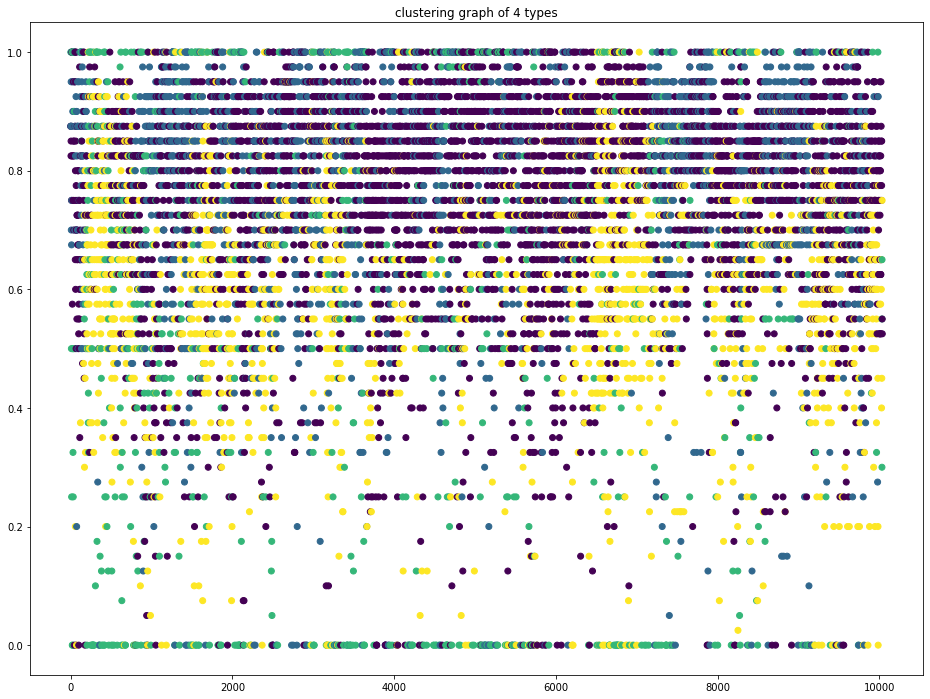

In [48]:
model = KMeans(init = 'random', n_clusters = 4).fit(df_sum)
df_sum['clustering'] = model.labels_
plt.figure(figsize = (16, 12))
plt.scatter(x = [i for i in range(len(df_sum))], y = df_sum['rating'], c = df_sum['clustering'])
plt.title("clustering graph of 4 types")
plt.show()

<Figure size 2160x1800 with 0 Axes>

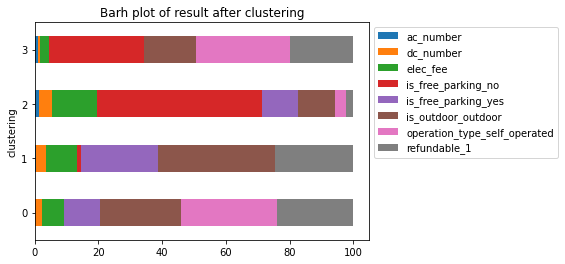

In [49]:
# use barh plot to display the result after clustering

values = ['operation_type_self_operated',
       'is_outdoor_outdoor', 'is_free_parking_no', 'is_free_parking_yes',
       'refundable_1','elec_fee', 'dc_number', 'ac_number']
plt.figure(figsize = (30, 25))
pivot2 = df_sum.pivot_table(index = ['clustering'], values = values, aggfunc = 'sum')
plot_cluster_percentage = pivot2.div(pivot2.sum(axis=1), axis=0) * 100
plot_cluster_percentage.plot(kind='barh', stacked=True) 
plt.legend(plot_cluster_percentage, bbox_to_anchor=(1,1))
plt.title("Barh plot of result after clustering")
plt.show()